In [32]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from glob import glob
import os
from statsmodels.stats.multitest import fdrcorrection
from scipy.cluster.hierarchy import fclusterdata, linkage
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
from Bio.Graphics import GenomeDiagram
from reportlab.lib.colors import Color
from reportlab.lib.units import inch
from IPython.display import Image
from Bio import SearchIO, SeqIO, Phylo, SeqFeature

workingDir="/pollard/home/xiaofanj/gut-community-microcosms/"

In [33]:
strainInfoDf=pd.read_csv(os.path.join(workingDir,'data','supplements','TableS1.csv'))
strainInfoDf['superphylum']=[phylum.split('_')[2] for phylum in strainInfoDf.phylum]
kolistDf=pd.read_csv(os.path.join(workingDir,'data','kofamInfo','ko_list'),sep="\t",index_col=0)
ninjamapDf=pd.read_csv(os.path.join(workingDir,'data','supplements','TableS2.csv'))
phyloDistDf=pd.read_csv(os.path.join(workingDir,'data','trees','biohubDistmat_gtdbPrunedUltrametric.csv'),index_col=0)
ggtreeCmap=['#F8766D','#CD9600','#7CAE00','#00BE67','#00BFC4','#00A9FF','#C77CFF','#FF61CC']


In [34]:
def rowColorsFromCatSeries(catSeries,cmap='tab20'):
    numCats=catSeries.nunique()
    if type(cmap) is str:
        colourMap=cm.get_cmap(cmap, numCats)(range(numCats))
    elif type(cmap) is list:
        colourMap=cmap
    else:
        return 
    catToColourDict=dict(zip(np.sort(catSeries.unique()), colourMap))
    row_colors=catSeries.map(catToColourDict)
    row_colors.index=catSeries.index
    return row_colors,catToColourDict

def plotCatRowColorLegend(catToColourDict,cmap='tab20',saveFig=None,rotation=0,order=None):
    numCats=len(catToColourDict)
    plt.figure(figsize=(3,0.5*numCats+2))
    if type(cmap) is str:
        colourMap=cm.get_cmap(cmap, numCats)
    elif type(cmap) is list:
        colourMap=colors.ListedColormap(cmap)
    else:
        return 
    if order is None:
        plt.imshow(np.expand_dims(np.arange(numCats), axis=1),cmap=colourMap)
        plt.gca().set_yticks(np.arange(numCats))
        plt.gca().set_yticklabels([key.split('__')[1] for key in catToColourDict.keys()],rotation=rotation)
    else:
        colorDf=pd.DataFrame([(key,catToColourDict[key]) for key in catToColourDict.keys()],
                             columns=['phylum','colour']).set_index('phylum')
        colorDf=colorDf.loc[order,:]
        colourMap=colors.ListedColormap(colorDf.colour)
        plt.imshow(np.expand_dims(np.arange(numCats), axis=1),cmap=colourMap)
        plt.gca().set_yticks(np.arange(numCats))
        plt.gca().set_yticklabels([key.split('__')[1] for key in colorDf.index],rotation=rotation)
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    if saveFig is not None:
        plt.savefig(saveFig)
        
def rowColorsFromContSeries(contSeries,cmap='seismic',divergent=True,name=None):
    #map mucosal enrichments based on species name
    colourMap=cm.get_cmap(cmap)
    if divergent:
        maxVal=np.nanmax(np.abs(np.asarray(contSeries)[np.isfinite(contSeries)]))
        norm = colors.Normalize(vmin=-maxVal,vmax=maxVal)
    else:
        maxVal=np.nanmax(np.abs(np.asarray(contSeries)[np.isfinite(contSeries)]))
        minVal=np.nanmin(np.abs(np.asarray(contSeries)[np.isfinite(contSeries)]))
        norm = colors.Normalize(vmin=minVal,vmax=maxVal)        
    row_colors=pd.Series(list(colourMap(norm(contSeries))))
    row_colors.index=contSeries.index
    if name is not None:
        row_colors.name=name
    else:
        row_colors.name=contSeries.name
    return row_colors

def linkageFromDistDf(phyloDistsDf,speciesList=None,method='complete'):
    if speciesList is None:
        speciesList=phyloDistsDf.index
    return scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(phyloDistsDf.loc[speciesList,speciesList].values),method=method)

/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


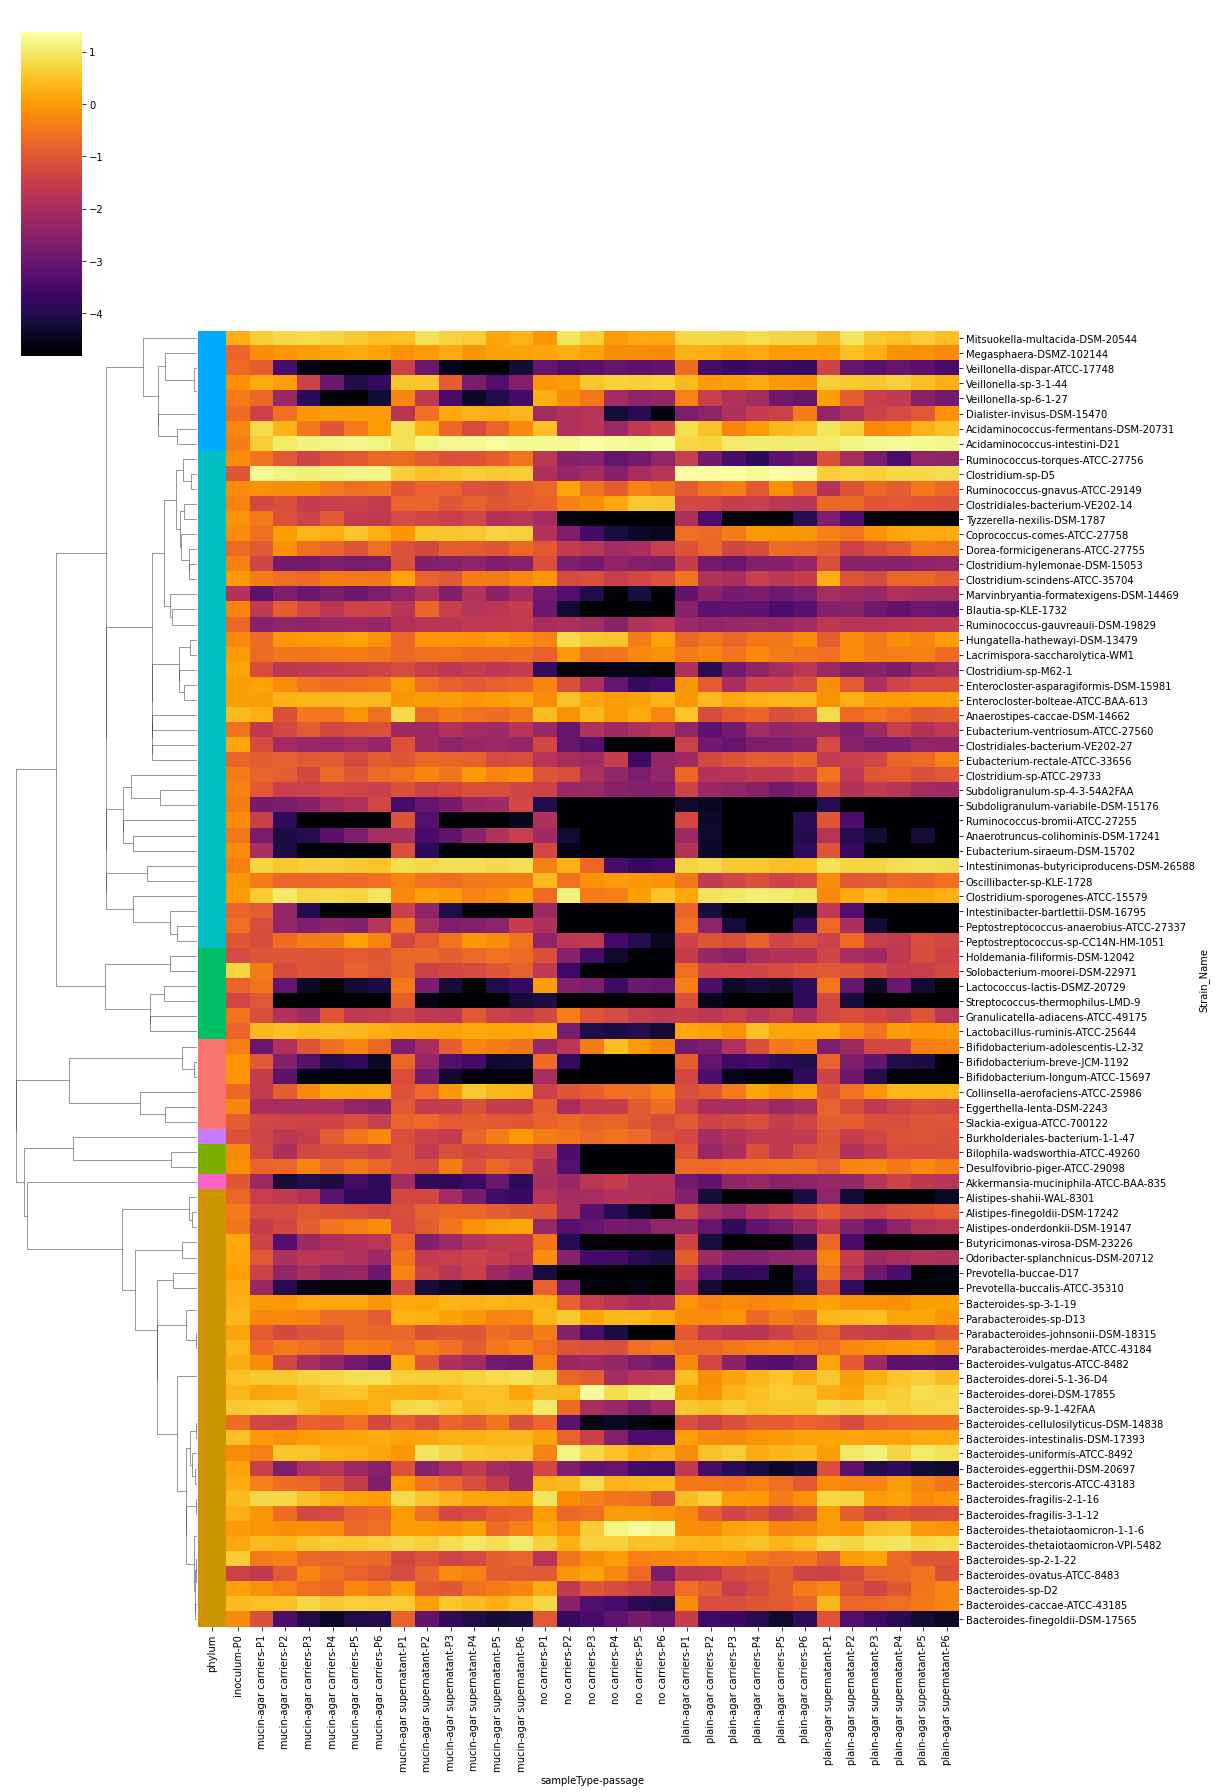

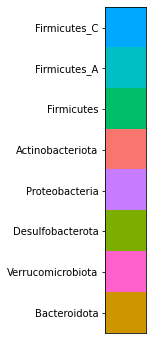

In [35]:
#dropping two strains from genome database that were intentionally excluded from experiment (B rodentium and L plantarum)
inoculatedStrains=[strain for strain in strainInfoDf.Strain if 'rodentium' not in strain and 'plantarum' not in strain]
ninjamapDf=ninjamapDf[ninjamapDf.Strain_Name.isin(inoculatedStrains)]

ninjamapDf['replicateLetter']=[replicate[2] for replicate in ninjamapDf.replicate]
ninjamapDf['replicateNumber']=[replicate[1] for replicate in ninjamapDf.replicate]
medianAbundances=ninjamapDf.groupby(['Strain_Name','sampleType','passage','replicateNumber']).median().reset_index()[['Strain_Name','sampleType','passage','replicateNumber','Read_Fraction']]

minRead_Fraction=0.01
minPercent_Coverage=1
numSamples=len(ninjamapDf.loc[ninjamapDf.sampleType!='inoculum',['sampleType','passage','replicate']].drop_duplicates())
presenceCounts=ninjamapDf[(ninjamapDf.Percent_Coverage>minPercent_Coverage)&(ninjamapDf.Read_Fraction>minRead_Fraction)&(ninjamapDf.sampleType!="inoculum")].groupby('Strain_Name')['Read_Fraction'].count()
prevalentStrains=presenceCounts[presenceCounts>0.1*numSamples].index

medianAbundances=medianAbundances.set_index(['Strain_Name','passage','sampleType','replicateNumber'])['Read_Fraction'].unstack().unstack().unstack().fillna(0).stack().stack().stack().reset_index().groupby(['Strain_Name','passage','sampleType']).median().unstack().unstack().droplevel(0,axis=1)
medianAbundances=medianAbundances.loc[prevalentStrains,(medianAbundances.sum()>0)]

vmin=np.nanmin(np.log10(medianAbundances).replace(-np.inf, np.nan).values)
phylaMapDf=medianAbundances.join(strainInfoDf[['Strain','phylum']].set_index('Strain'))

g=sns.clustermap(np.log10(medianAbundances).replace(-np.inf, vmin),
                   cmap="inferno",
                   vmin=np.nanmin(np.log10(medianAbundances).replace(-np.inf, np.nan).values),
                   vmax=np.nanmax(np.log10(medianAbundances).values),col_cluster=False,
                   figsize=(17,25),row_colors=rowColorsFromCatSeries(phylaMapDf.phylum,cmap=ggtreeCmap)[0],
                   row_linkage=linkageFromDistDf(phyloDistDf,prevalentStrains),
                    xticklabels=1, yticklabels=1)
plotCatRowColorLegend(rowColorsFromCatSeries(phylaMapDf.phylum,cmap=ggtreeCmap)[1],cmap=ggtreeCmap,
                     order=phylaMapDf.phylum[[label.get_text() for label in g.ax_heatmap.get_yticklabels()]].unique())



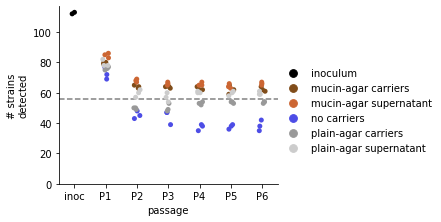

In [36]:
minRead_Fraction=0.01
minPercent_Coverage=1
ninjaFilterDf=ninjamapDf[(ninjamapDf.Read_Fraction>minRead_Fraction) & (ninjamapDf.Percent_Coverage>minPercent_Coverage)]
speciesCounts=ninjaFilterDf.groupby(['sampleType','passage','replicateNumber','replicateLetter'])['Read_Fraction'].count().unstack().median(axis=1).reset_index().rename(columns={0:'speciesCount'})
speciesCounts
g=sns.catplot(x="passage",  y="speciesCount",hue='sampleType',kind='strip',data=speciesCounts,
              palette=[(0,0,0),(0.5,0.3,0.1),(0.8,0.4,0.2),(0.3,0.3,0.9),(0.6,0.6,0.6),(0.8,0.8,0.8)],aspect=1.3,height=3,
             order=['P0','P1','P2','P3','P4','P5','P6'], facet_kws={'legend_out': True})
g.set_axis_labels(y_var="# strains\ndetected")
g.set(xticklabels=['inoc','P1','P2','P3','P4','P5','P6'])
g.set(ylim=(0, None))
g.ax.axhline(y=56,color='gray',linestyle='--')
g._legend.set_title("")


In [40]:
ninjamapDf

,sampleType,passage,replicate,Strain_Name,Read_Fraction,Percent_Coverage,replicateLetter,replicateNumber
0,plain-agar carriers,P1,R1a,Acidaminococcus-fermentans-DSM-20731,9.356789,99.893866,a,1
1,plain-agar carriers,P1,R1a,Acidaminococcus-intestini-D21,3.090456,99.858891,a,1
2,plain-agar carriers,P1,R1a,Adlercreutzia-equolifaciens-DSM-19450,0.001039,0.337918,a,1
3,plain-agar carriers,P1,R1a,Akkermansia-muciniphila-ATCC-BAA-835,0.001427,0.479763,a,1
4,plain-agar carriers,P1,R1a,Alistipes-finegoldii-DSM-17242,0.050384,11.653780,a,1
...,...,...,...,...,...,...,...,...
25697,inoculum,P0,R2c,Subdoligranulum-variabile-DSM-15176,0.389778,56.425669,c,2
25698,inoculum,P0,R2c,Tyzzerella-nexilis-DSM-1787,0.902691,78.685790,c,2
25699,inoculum,P0,R2c,Veillonella-dispar-ATCC-17748,0.218147,51.193586,c,2
25700,inoculum,P0,R2c,Veillonella-sp-3-1-44,0.773218,90.408281,c,2


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


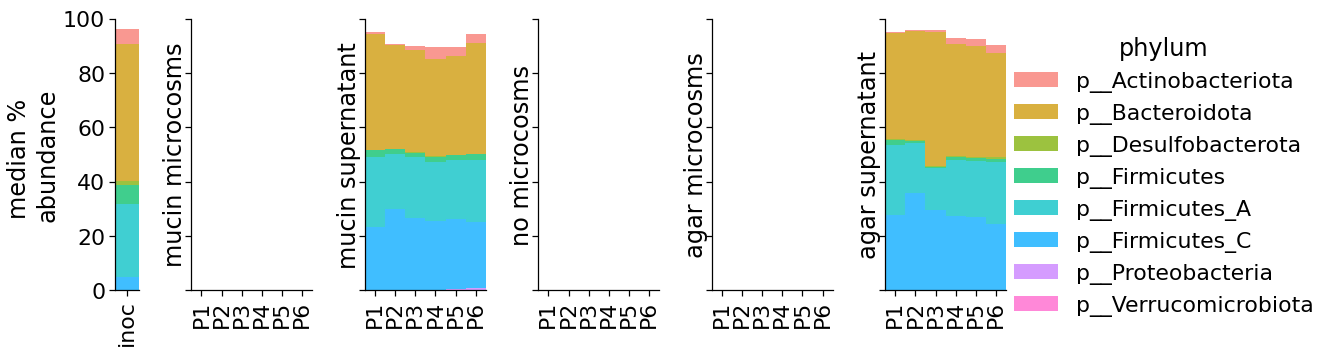

In [45]:
ninjaPhylaDf=ninjamapDf.set_index('Strain_Name').join(strainInfoDf[['Strain','phylum']].set_index('Strain'),how='left').groupby(['sampleType','passage','replicate','phylum']).sum()['Read_Fraction'].reset_index()
ninjaPhylaDf['replicateLetter']=[replicate[2] for replicate in ninjaPhylaDf.replicate]
ninjaPhylaDf['replicateNumber']=[replicate[1] for replicate in ninjaPhylaDf.replicate]
phylaMedianDf=ninjaPhylaDf.groupby(['phylum','sampleType','passage','replicateNumber']).median().reset_index().groupby(['phylum','sampleType','passage']).median().reset_index()
with sns.plotting_context("notebook",font_scale=2):
    g=sns.displot(x="passage",  weights="Read_Fraction", multiple='stack',hue='phylum',kind='hist',linewidth=0,
                col='sampleType',aspect=.5,
                data=phylaMedianDf.sort_values(by=['passage','sampleType']),
                 palette=['#F8766D','#CD9600','#7CAE00','#00BE67','#00BFC4','#00A9FF','#C77CFF','#FF61CC'],
                 facet_kws={'col_order':['inoculum', 
                                         'mucin-agar microcosms',
                                         'mucin-agar supernatant',
                                         'no microcosms',
                                         'plain-agar microcosms',
                                         'plain-agar supernatant'],'sharex':False,
                           'gridspec_kws':{'width_ratios': [1, 5,5,5,5,5],"hspace":.5,"wspace":.5}})
    g.set_axis_labels('', '') 
    
    g.set(ylim=(0, 100))
    g.axes[0,0].set(ylabel="median % \nabundance")
    g.axes[0,0].set(title="")
    g.axes[0,0].set_xlim(-.5, .5)
    g.axes[0,0].set_xticklabels(["inoc"]+[f"P{passage}" for passage in range(1,7)],rotation=90)
    
    g.axes[0,1].set(ylabel="mucin microcosms")
    g.axes[0,2].set(ylabel="mucin supernatant")
    g.axes[0,3].set(ylabel="no microcosms")
    g.axes[0,4].set(ylabel="agar microcosms")
    g.axes[0,5].set(ylabel="agar supernatant")

    for colInd in range(1,6):
        g.axes[0,colInd].set(title="")
        g.axes[0,colInd].set_xlim(0.5, 6.5)
        g.axes[0,colInd].set_xticklabels(["inoc"]+[f"P{passage}" for passage in range(1,7)],rotation=90)
    

In [46]:
medianAbundances=ninjamapDf.groupby(['Strain_Name','sampleType','passage','replicateNumber']).median().reset_index()[['Strain_Name','sampleType','passage','replicateNumber','Read_Fraction']]

def makeAbundancePlots(strainsToCompare,ninjaMedianDf=medianAbundances,logScale=True,palette=None,relAbPercent=True):
    sampleTypes=ninjaMedianDf.sampleType.unique()
    df=ninjaMedianDf[(ninjaMedianDf.Strain_Name.isin(strainsToCompare))&(ninjaMedianDf.sampleType.isin(sampleTypes))].rename(columns={"Read_Fraction":"percentAbundance"})

    for sampleType in df.sampleType.unique():
        if sampleType!='inoculum':
            df2=df[df.sampleType=='inoculum']
            df2['sampleType']=sampleType
            df=pd.concat([df,df2])
    df=df[df.sampleType!='inoculum']
    if not relAbPercent:
        df['percentAbundance']=df.percentAbundance/100
        ylabel='frac. rel. abund.'
    else:
        ylabel='% rel. abund.'
        
            

    with sns.plotting_context("notebook",font_scale=1.4):
        g=sns.catplot(kind='strip',data=df,x='passage',y='percentAbundance',hue='Strain_Name',col='sampleType',col_wrap=2,
                      palette=palette,
                aspect=1.2,height=3,order=['P0','P1','P2','P3','P4','P5','P6'], facet_kws={'legend_out': True})
        if logScale:
            g.set(yscale='log')
        else:
            g.set(ylim=(0, None))
        g.set_axis_labels(y_var=ylabel)
        g.set(xticklabels=['inoc','P1','P2','P3','P4','P5','P6'])
        for ax in g.axes:
            ax.set(title=ax.get_title().split(" = ")[1])
        g._legend.set_title("")
        for label in g._legend.texts:
            strings=label.get_text().split('-')
            label.set_text('\n'.join(['-'.join(strings[:2]),'-'.join(strings[2:])]))
         
    

/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWit

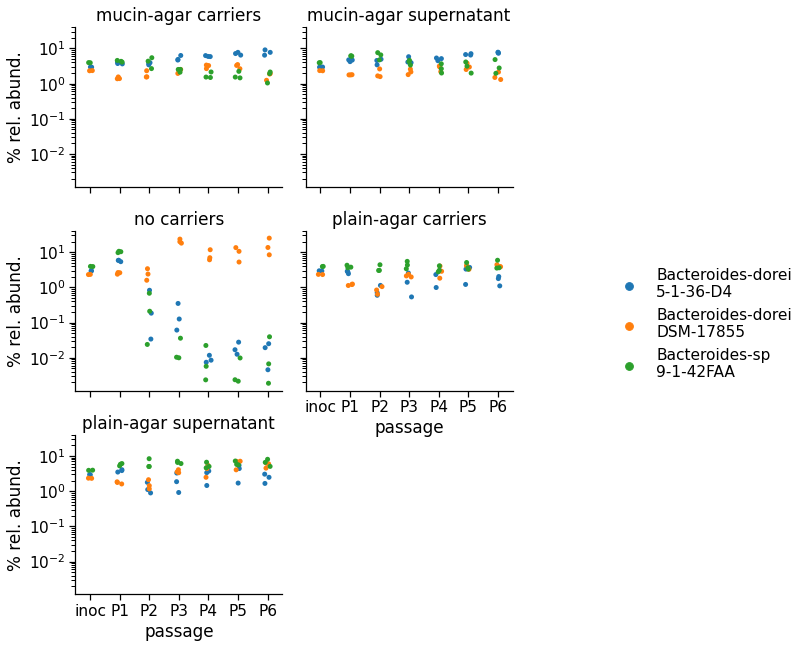

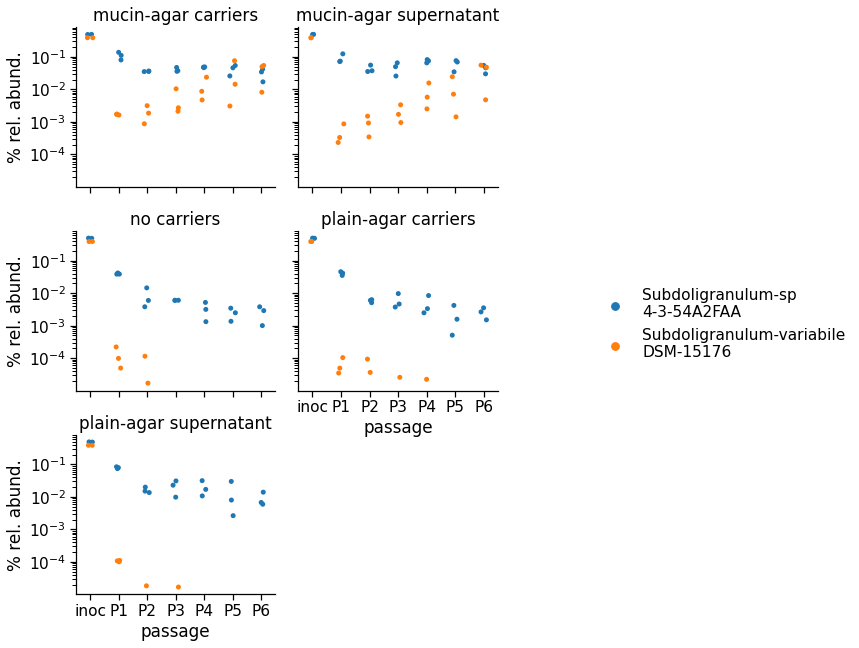

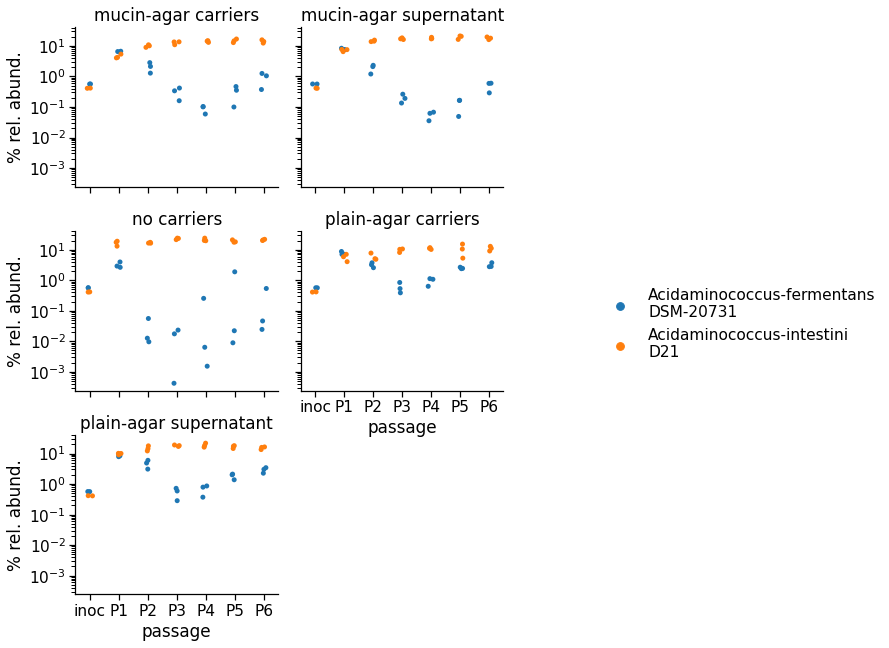

In [47]:
makeAbundancePlots(['Bacteroides-dorei-5-1-36-D4','Bacteroides-dorei-DSM-17855','Bacteroides-sp-9-1-42FAA'])
makeAbundancePlots(['Subdoligranulum-variabile-DSM-15176','Subdoligranulum-sp-4-3-54A2FAA'])
makeAbundancePlots(['Acidaminococcus-fermentans-DSM-20731','Acidaminococcus-intestini-D21'])         

In [49]:
medianAbundances=ninjamapDf.groupby(['Strain_Name','sampleType','passage','replicateNumber']).median().reset_index()[['Strain_Name','sampleType','passage','replicateNumber','Read_Fraction']]
# medianAbundances=medianAbundances.join(strainInfoDf.set_index('Strain'),how='left')

# minRead_Fraction=0.01
# minPercent_Coverage=1
# numSamples=len(ninjamapDf.loc[ninjamapDf.sampleType!='inoculum',['sampleType','passage','replicate']].drop_duplicates())
# presenceCounts=ninjamapDf[(ninjamapDf.Percent_Coverage>minPercent_Coverage)&(ninjamapDf.Read_Fraction>minRead_Fraction)&(ninjamapDf.sampleType!="inoculum")].groupby('Strain_Name')['Read_Fraction'].count()
# prevalentStrains=presenceCounts[presenceCounts>0.1*numSamples].index

# medianAbundances=medianAbundances.set_index(['Strain_Name','passage','sampleType','replicateNumber'])['Read_Fraction'].unstack().unstack().unstack().fillna(0).stack().stack().stack().reset_index().groupby(['Strain_Name','passage','sampleType']).median().unstack().unstack().droplevel(0,axis=1)
# medianAbundances=medianAbundances.loc[prevalentStrains,(medianAbundances.sum()>0)]
# medianAbundances

floor=np.nanmin(medianAbundances.Read_Fraction[medianAbundances.Read_Fraction>0])/2
floor

medianEnrichments=medianAbundances[medianAbundances.passage != 'inoculum'].set_index(['passage','replicateNumber','sampleType','Strain_Name'])['Read_Fraction'].unstack().unstack().fillna(0).replace(0,floor)
for species in medianEnrichments.columns.levels[0]:
    medianEnrichments[species,'mucin-agar log carrier enrichment']=np.log(medianEnrichments[species,'mucin-agar carriers']/medianEnrichments[species,'mucin-agar supernatant'])
    medianEnrichments[species,'plain-agar log carrier enrichment']=np.log(medianEnrichments[species,'plain-agar carriers']/medianEnrichments[species,'plain-agar supernatant'])
    
medianEnrichments=medianEnrichments.loc[:,[(strain,'mucin-agar log carrier enrichment') for strain in prevalentStrains]].stack().stack().reset_index().groupby(['passage','Strain_Name']).median().unstack().T.droplevel(0,axis=0).drop('P0',axis=1)
medianEnrichments

passage,P1,P2,P3,P4,P5,P6
Strain_Name,,,,,,
Acidaminococcus-fermentans-DSM-20731,-0.143561,0.067138,0.463013,0.508302,0.770408,0.557817
Acidaminococcus-intestini-D21,-0.582300,-0.354901,-0.299342,-0.253036,-0.366978,-0.142913
Akkermansia-muciniphila-ATCC-BAA-835,-0.526285,-0.620596,-0.371065,-0.978281,-1.078353,-0.035092
Alistipes-finegoldii-DSM-17242,-0.141887,-0.864590,-0.474294,-0.887164,-0.467892,-0.804411
Alistipes-onderdonkii-DSM-19147,-0.449799,-0.825379,-0.704081,-0.915739,-0.594534,-0.812642
...,...,...,...,...,...,...
Subdoligranulum-variabile-DSM-15176,1.593896,0.930383,0.799707,0.414570,0.765523,0.041387
Tyzzerella-nexilis-DSM-1787,1.878325,0.985004,0.323821,0.859652,0.618273,0.416778
Veillonella-dispar-ATCC-17748,1.271304,-0.761966,-0.080067,0.000000,0.000000,0.000000


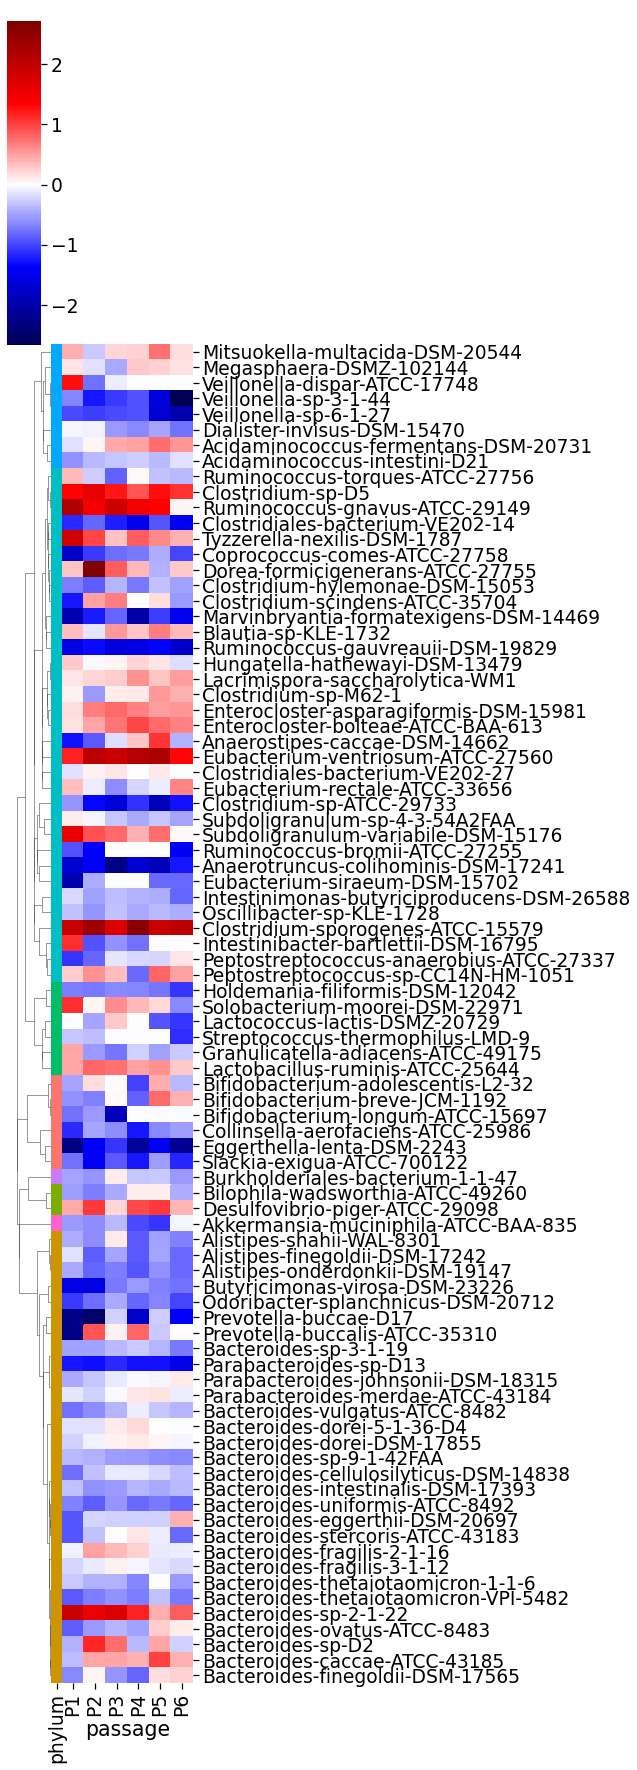

In [50]:
with sns.plotting_context("notebook",font_scale=1.7):
    g=sns.clustermap(medianEnrichments,
                   center=0,cmap="seismic",
                   figsize=(9.5,25),row_colors=rowColorsFromCatSeries(phylaMapDf.phylum,cmap=ggtreeCmap)[0],
                   row_linkage=linkageFromDistDf(phyloDistDf,prevalentStrains),col_cluster=False,
                    xticklabels=1, yticklabels=1, colors_ratio=0.06)
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),rotation = 90)


In [52]:
ninjaPhylaDf=ninjamapDf.set_index('Strain_Name').join(strainInfoDf[['Strain','phylum']].set_index('Strain'),how='left').groupby(['sampleType','passage','replicate','phylum']).sum()['Read_Fraction'].reset_index()
ninjaPhylaDf['replicateLetter']=[replicate[2] for replicate in ninjaPhylaDf.replicate]
ninjaPhylaDf['replicateNumber']=[replicate[1] for replicate in ninjaPhylaDf.replicate]
phylaMedianDf=ninjaPhylaDf.groupby(['phylum','sampleType','passage','replicateNumber']).median().reset_index()
floor=np.nanmin(phylaMedianDf.Read_Fraction[phylaMedianDf.Read_Fraction>0])/2
medianPhylaEnrichments=phylaMedianDf[ninjaPhylaDf.passage != 'inoculum'].set_index(['passage','replicateNumber','sampleType','phylum'])['Read_Fraction'].unstack().unstack().fillna(0).replace(0,floor)
for phylum in medianPhylaEnrichments.columns.levels[0]:
    medianPhylaEnrichments[phylum,'mucin-agar log carrier enrichment']=np.log(medianPhylaEnrichments[phylum,'mucin-agar carriers']/medianPhylaEnrichments[phylum,'mucin-agar supernatant'])
    medianPhylaEnrichments[phylum,'plain-agar log carrier enrichment']=np.log(medianPhylaEnrichments[phylum,'plain-agar carriers']/medianPhylaEnrichments[phylum,'plain-agar supernatant'])
medianPhylaEnrichments=medianPhylaEnrichments.drop('P0')
medianPhylaEnrichments


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


phylum                  p__Actinobacteriota                      \
sampleType                         inoculum mucin-agar carriers   
passage replicateNumber                                           
P1      1                          0.000008            0.175627   
        2                          0.000008            0.288253   
        3                          0.000008            0.281482   
P2      1                          0.000008            0.204277   
        2                          0.000008            0.214683   
        3                          0.000008            0.215339   
P3      1                          0.000008            0.597170   
        2                          0.000008            0.624382   
        3                          0.000008            0.885396   
P4      1                          0.000008            1.758138   
        2                          0.000008            1.038917   
        3                          0.000008            2.111434   
P5      1                          0.000008            2.651190   
        2                          0.000008            2.087225   
        3                          0.000008            1.898859   
P6      1                          0.000008            2.443965   
        2                          0.000008            1.637122   
        3                          0.000008            1.984221   

phylum                                                      \
sampleType              mucin-agar supernatant no carriers   
passage replicateNumber                                      
P1      1                             0.823701    0.629412   
        2                             0.571452    0.616257   
        3                             0.717092    0.635990   
P2      1                             0.368086    0.379323   
        2                             0.526308    0.358458   
        3                             0.566189    0.293526   
P3      1                             1.284090    0.685787   
        2                             1.180065    1.776822   
        3                             1.292191    0.669511   
P4      1                             3.983133    4.245079   
        2                             4.098240    3.746022   
        3                             6.889634    2.951095   
P5      1                             3.480876    1.533491   
        2                             3.348022    2.365337   
        3                             2.563640    0.663930   
P6      1                             3.196825    2.026036   
        2                             2.493260    0.769268   
        3                             4.249622    1.381533   

phylum                                                              \
sampleType              plain-agar carriers plain-agar supernatant   
passage replicateNumber                                              
P1      1                          0.400725               0.598462   
        2                          0.525189               0.559750   
        3                          0.505381               0.765313   
P2      1                          0.239459               0.765952   
        2                          0.171205               0.491652   
        3                          0.123792               0.300876   
P3      1                          0.605720               2.142656   
        2                          0.446460               0.889597   
        3                          0.272199               0.327272   
P4      1                          1.653799               2.424477   
        2                          1.633374               3.336478   
        3                          0.816914               1.531129   
P5      1                          1.429017               2.947634   
        2                          0.727045               2.833535   
        3                          1.325932               2.703144   
P6      1                    

<Figure size 432x288 with 0 Axes>

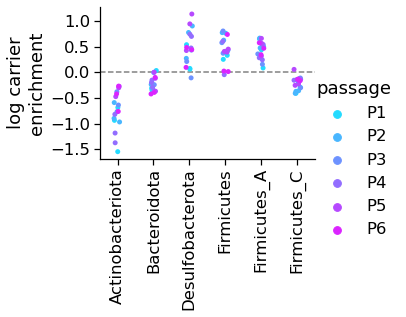

In [53]:
phylaCounts=strainInfoDf.phylum.value_counts()
palette='cool'
plt.figure()
with sns.plotting_context("notebook",font_scale=1.5):
    sns.catplot(x='phylum',y='mucin-agar log carrier enrichment',hue='passage',palette=palette,aspect=1.5,height=3,
                 data=medianPhylaEnrichments[[(phylum,'mucin-agar log carrier enrichment') for phylum in phylaCounts[phylaCounts>1].index]].stack().stack().reset_index().drop('sampleType',axis=1).rename(columns={0:'mucin-agar log carrier enrichment'}))

    plt.gca().set_ylabel('log carrier\nenrichment')
    plt.gca().set_xlabel('')
    plt.gca().set_xticklabels([label.get_text().split('__')[1] for label in plt.gca().get_xticklabels()],rotation=90)
    plt.axhline(y=0, color='grey', linestyle='--')


In [54]:
floor=np.nanmin(medianAbundances.Read_Fraction[medianAbundances.Read_Fraction>0])/2
floor

medianEnrichments=medianAbundances[medianAbundances.passage != 'inoculum'].set_index(['passage','replicateNumber','sampleType','Strain_Name'])['Read_Fraction'].unstack().unstack().fillna(0).replace(0,floor)
for species in medianEnrichments.columns.levels[0]:
    medianEnrichments[species,'mucin-agar log carrier enrichment']=np.log(medianEnrichments[species,'mucin-agar carriers']/medianEnrichments[species,'mucin-agar supernatant'])
    medianEnrichments[species,'plain-agar log carrier enrichment']=np.log(medianEnrichments[species,'plain-agar carriers']/medianEnrichments[species,'plain-agar supernatant'])
medianEnrichments=medianEnrichments.drop('P0')

In [57]:
def makeEnrichmentPlots(strainsToCompare,ninjaPercentDf=medianEnrichments,logScale=False,palette=None):
    enrichmentTypes=[sampleType for sampleType in ninjaPercentDf.columns.levels[1] if 'enrichment' in sampleType]
    
    df=ninjaPercentDf[[(strain,sampleType) for strain in strainsToCompare for sampleType in enrichmentTypes]].stack().stack().reset_index().rename(columns={0:'logEnrichment'})
    aspect=1.3

    with sns.plotting_context("notebook",font_scale=1.4):
        g=sns.catplot(kind='strip',data=df.replace(0,np.nan),x='passage',y='logEnrichment',hue='Strain_Name',col='sampleType',
                      palette=palette,
                      aspect=aspect,height=4,
                     facet_kws={'legend_out': True})
        g.set(ylabel='log microcosm\nenrichment')
        g._legend.set_title("")
#         g._legend.set_bbox_to_anchor((0, -.25, 0.5, 0.5))
        if len(enrichmentTypes)>1:
            for ax1 in g.axes:
                for ind,ax2 in enumerate(ax1):
                    ax2.set(title=ax2.get_title().split(" = ")[1])
                    ax2.axhline(y=0, color='grey', linestyle='--')
                    if ind>0:
                        ax2.set(ylabel="")
        else:
            for ax1 in g.axes:
                for ax2 in ax1:
                    ax2.set(title="")
                    ax2.axhline(y=0, color='grey', linestyle='--')
        for label in g._legend.texts:
            strings=label.get_text().split('-')
            label.set_text('\n'.join(['-'.join(strings[:2]),'-'.join(strings[2:])]))


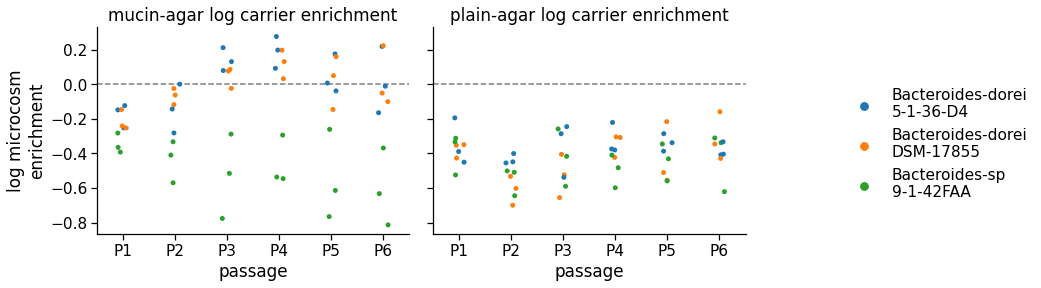

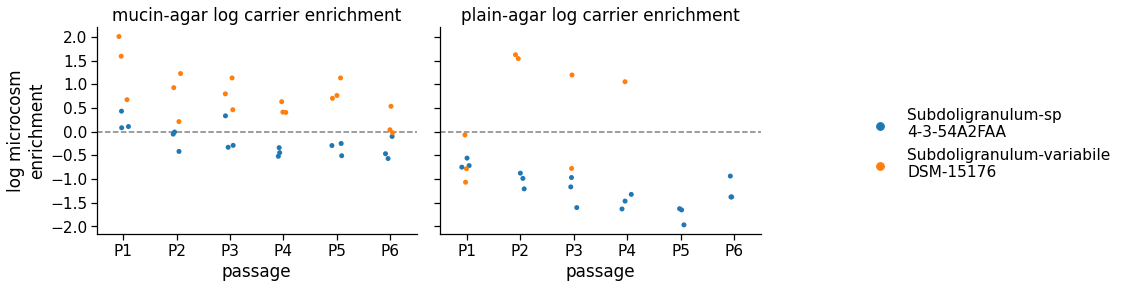

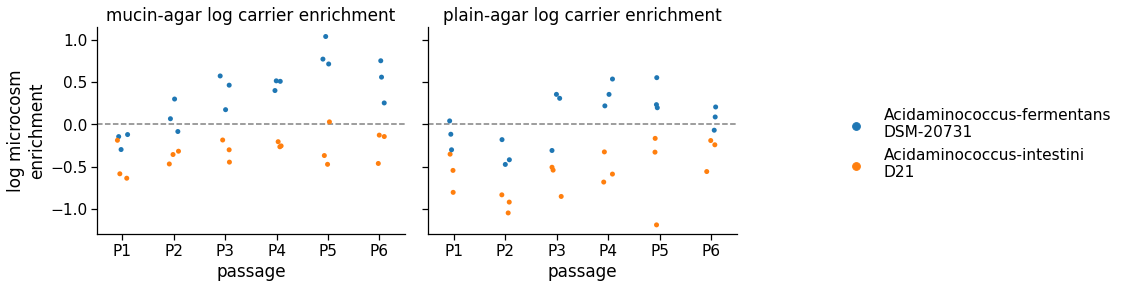

In [58]:
makeEnrichmentPlots(['Bacteroides-dorei-5-1-36-D4','Bacteroides-dorei-DSM-17855','Bacteroides-sp-9-1-42FAA'])
makeEnrichmentPlots(['Subdoligranulum-variabile-DSM-15176','Subdoligranulum-sp-4-3-54A2FAA'])
makeEnrichmentPlots(['Acidaminococcus-fermentans-DSM-20731','Acidaminococcus-intestini-D21']) 

In [59]:
aggregateEnrichments=medianEnrichments.drop(['P1','P2']).stack().stack().reset_index()
aggregateEnrichments=aggregateEnrichments[aggregateEnrichments.sampleType.str.contains('enrichment')]

means=aggregateEnrichments.groupby(['sampleType','Strain_Name'])[0].mean()
stdevs=aggregateEnrichments.groupby(['sampleType','Strain_Name'])[0].std()
aggregateEnrichments=(means/stdevs).unstack().T
aggregateEnrichments.columns=[col+' aggregate mean/stdev P3-6' for col in aggregateEnrichments.columns]
aggregateEnrichments

,mucin-agar log carrier enrichment aggregate mean/stdev P3-6,plain-agar log carrier enrichment aggregate mean/stdev P3-6
Strain_Name,,
Acidaminococcus-fermentans-DSM-20731,2.366514,0.927934
Acidaminococcus-intestini-D21,-1.739071,-1.723932
Adlercreutzia-equolifaciens-DSM-19450,-1.536412,-0.302168
Akkermansia-muciniphila-ATCC-BAA-835,-0.403543,-5.652460
Alistipes-finegoldii-DSM-17242,-2.284787,-3.155063
...,...,...
Turicibacter-sanguinis-DSM-14220,0.288675,NaN
Tyzzerella-nexilis-DSM-1787,1.820771,0.424679
Veillonella-dispar-ATCC-17748,-0.265218,-1.091986


In [60]:
kofamscanCsvs=glob(os.path.join(workingDir,'data','kofamscan','*.csv.gz'))
def csvToMaxNormBitscoreDf(csvFile):
    df=pd.read_csv(csvFile)
    df['normBitscore']=df.hit_bitscore/df.bitscore_threshold
    maxNormBitscoreDf=df[df.hit_overlapFrac>0.5].groupby(['hmm_queryID']).max()['normBitscore'].reset_index()
    maxNormBitscoreDf['strainName']=os.path.basename(csvFile).split('_')[0]
    return maxNormBitscoreDf.dropna()
def csvFilesToDf(csvFileList,outFile=None):
    df=pd.concat([csvToMaxNormBitscoreDf(csvFile) for csvFile in csvFileList])
    df=df.set_index(['strainName','hmm_queryID']).unstack().droplevel(0,axis=1).fillna(0).reset_index()
    df=df.drop_duplicates(subset=['strainName']).sort_values(by='strainName')
    return df
kofamscanDf=csvFilesToDf(kofamscanCsvs).set_index('strainName')
kofamscanDf

hmm_queryID,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,K00009,K00010,...,K24697,K24698,K24699,K24700,K24707,K24708,K24709,K24710,K24711,K24712
strainName,,,,,,,,,,,,,,,,,,,,,
Acidaminococcus-fermentans-DSM-20731,0.442297,0.726205,1.900164,0.424077,1.393039,0.824284,0.000000,0.488419,0.000000,0.346250,...,0.447635,0.000000,0.0,0.000000,0.000000,0.773263,0.000000,0.000000,0.000000,0.099033
Acidaminococcus-intestini-D21,0.497964,0.645228,1.836720,0.447514,0.000000,0.785699,0.000000,0.501128,0.000000,0.267117,...,0.000000,0.000000,0.0,0.000000,0.000000,0.767703,0.000000,0.000000,0.000000,0.000000
Adlercreutzia-equolifaciens-DSM-19450,0.000000,0.084599,1.803953,0.000000,0.169585,0.737157,0.000000,0.000000,0.000000,0.297953,...,0.375217,0.000000,0.0,0.000000,0.278801,0.673180,0.277152,0.298246,0.405743,0.000000
Akkermansia-muciniphila-ATCC-BAA-835,0.545047,0.671099,1.704605,0.732898,0.156751,0.791922,0.000000,0.765440,0.000000,0.685812,...,0.000000,0.000000,0.0,0.000000,0.264097,0.562638,0.194021,0.440989,0.352999,0.114386
Alistipes-finegoldii-DSM-17242,0.000000,0.751041,0.000000,0.000000,0.119473,0.543299,0.139023,0.000000,2.813528,0.637144,...,0.000000,0.420468,0.0,0.287911,0.256531,0.676622,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Turicibacter-sanguinis-DSM-14220,0.261722,0.729568,0.000000,0.000000,1.656125,0.823972,0.268613,0.000000,0.000000,0.545009,...,0.000000,0.000000,0.0,0.000000,0.278087,0.715676,0.151293,0.428228,0.445986,0.000000
Tyzzerella-nexilis-DSM-1787,0.215194,0.680930,1.903301,0.000000,0.111223,0.782587,0.000000,0.000000,0.000000,0.795037,...,0.000000,0.000000,0.0,0.000000,0.515203,0.780545,0.237040,0.565348,0.563977,0.141681
Veillonella-dispar-ATCC-17748,0.258676,0.655059,1.793495,0.000000,0.685672,0.758938,0.000000,0.000000,0.000000,0.230338,...,0.000000,0.000000,0.0,0.000000,0.000000,0.819069,0.213350,0.601034,0.488767,0.000000


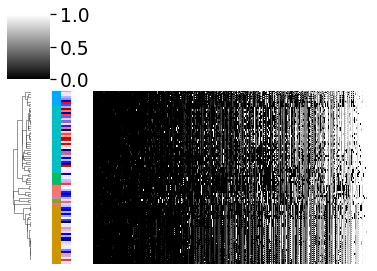

In [61]:
kofamscanDf=kofamscanDf.loc[kofamscanDf.index.isin(prevalentStrains),:]
hitCounts=kofamscanDf.sum()
kofamscanDf=kofamscanDf[hitCounts[hitCounts>0].index]

row_colors=rowColorsFromCatSeries(phylaMapDf.phylum,cmap=ggtreeCmap)[0],
row_linkage=linkageFromDistDf(phyloDistDf,prevalentStrains)
                        
rowcolorsPhylum,_=rowColorsFromCatSeries(phylaMapDf.phylum,cmap=ggtreeCmap)
rowcolorsEnrichment=rowColorsFromContSeries(aggregateEnrichments['mucin-agar log carrier enrichment aggregate mean/stdev P3-6'],name='carrier\nenrichment')

with sns.plotting_context("notebook",font_scale=1.7):
    g=sns.clustermap(kofamscanDf[kofamscanDf.clip(upper=1).sum().sort_values().index],
               figsize=(12,5),
               row_linkage=linkageFromDistDf(phyloDistDf,prevalentStrains),
#                col_cluster=False,
               vmin=0,vmax=1,cmap='gray',
               row_colors=pd.concat([rowcolorsPhylum,rowcolorsEnrichment],axis=1),
               dendrogram_ratio=(0.06,0.1),
                  yticklabels=1,
                col_cluster=False,
#                colors_ratio,
              method='weighted')
    g.ax_col_dendrogram.set_visible(False)
    g.ax_heatmap.get_xaxis().set_visible(False)
    g.ax_heatmap.get_yaxis().set_visible(False)
    x0, y0, w, h = g.cbar_pos
    g.ax_cbar.set_position([x0, y0+.1, w, h])
    g.ax_row_colors.set_xticks([])
#     g.cax.set_visible(False)


In [62]:
kofamscanDf.join(aggregateEnrichments['mucin-agar log carrier enrichment aggregate mean/stdev P3-6']).join(strainInfoDf.set_index('Strain').superphylum).to_csv(os.path.join(workingDir,'data','phylolm','kofamscanInput.csv.gz'))

,estimates,stderrs,tvals,pvals,hues,sizes,effect,definition
K08217,0.955566,0.072185,13.237816,2.920220e-22,2,2,0.955566,"MFS transporter, DHA3 family, macrolide efflux..."
K18215,1.117097,0.084798,13.173570,3.853550e-22,1,1,1.117097,"MFS transporter, DHA3 family, tetracycline res..."
K08225,1.170840,0.088972,13.159593,4.093496e-22,1,1,1.170840,"MFS transporter, ENTS family, enterobactin (si..."
K20530,1.858460,0.148221,12.538446,6.133860e-21,1,1,1.858460,type IV secretion system protein TrbE [EC:7.4....
K07458,0.774492,0.062086,12.474449,8.127083e-21,1,1,0.774492,"DNA mismatch endonuclease, patch repair protei..."
...,...,...,...,...,...,...,...,...
K18944,3.491576,0.953817,3.660637,4.385968e-04,1,1,3.491576,sliding clamp loader
K17248,0.686268,0.187705,3.656094,4.453447e-04,1,1,0.686268,"N-acetylgalactosamine-N,N'-diacetylbacillosami..."
K07492,0.360841,0.099448,3.628452,4.885805e-04,1,1,0.360841,putative transposase
K02491,2.954331,0.815430,3.623034,4.975103e-04,1,1,2.954331,"two-component system, sporulation sensor kinas..."


<Figure size 1080x720 with 0 Axes>

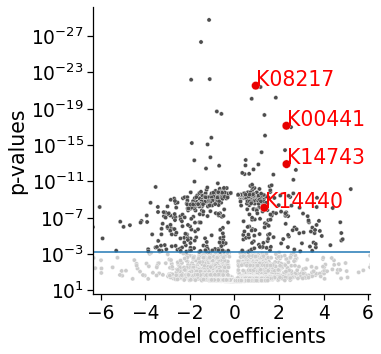

In [63]:
keggsToHighlight=['K14440','K00441','K14743','K08217']

plmDf=pd.read_csv(os.path.join(workingDir,"data","phylolm","kofamscanOutput_allPhyla.csv"),index_col=0)
sigThreshold=plmDf.pvals[fdrcorrection(plmDf.pvals,alpha=0.01)[0]].max()

plmDf['hues']=0
plmDf.loc[plmDf.pvals<sigThreshold,'hues']=1
plmDf.loc[plmDf.index.isin(keggsToHighlight),'hues']=2
plmDf['sizes']=1
plmDf.loc[plmDf.index.isin(keggsToHighlight),'sizes']=2
plmDf['effect']=plmDf.estimates
plt.figure(figsize=(15,10))
with sns.plotting_context("notebook",font_scale=1.7):

    g=sns.relplot(x='estimates',y='pvals',data=plmDf.sort_values(by='hues'),size='sizes',#alpha=0.2,
                      hue='hues',palette=[[0.8,0.8,0.8],[0.3,0.3,0.3],[0.9,0.0,0.0]],aspect=1,legend=False)
    for ax in g.axes:
        for ax2 in ax:
            
            ax2.invert_yaxis()
            ax2.set_yscale('log')
            ax2.set_xlim(np.quantile(plmDf[f'estimates'],[0.001,0.999]))
            ax2.set_ylabel('p-values')
            ax2.set_xlabel('model coefficients')
            ax2.axhline(sigThreshold)
            for x,y,label in zip(plmDf[f'estimates'], plmDf[f'pvals'],plmDf.index):
                if label in keggsToHighlight:
                    ax2.text(x+0.03, y, label, horizontalalignment='left', size='medium', color='red')

plmDf[(plmDf['pvals']<sigThreshold)&(plmDf['tvals']>0)].join(kolistDf.definition)


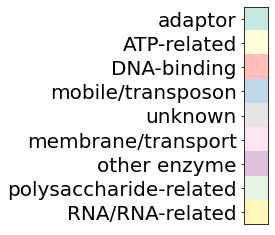

In [64]:
def plotCatRowColorLegend(catToColourDict,cmap='tab20',saveFig=None,rotation=0):
    numCats=len(catToColourDict)
    plt.figure(figsize=(3,0.5*numCats+2))
    if type(cmap) is str:
        colourMap=cm.get_cmap(cmap, numCats)
    elif type(cmap) is list:
        colourMap=colors.ListedColormap(cmap)
    else:
        return 
    plt.imshow(np.expand_dims(np.arange(numCats), axis=1),cmap=colourMap)
    plt.gca().set_yticks(np.arange(numCats))
    plt.gca().set_yticklabels([key.split('__')[1] for key in catToColourDict.keys()],rotation=rotation)
    if saveFig is not None:
        plt.savefig(saveFig)

geneTypes=['adaptor', 
           'atp', 
           'dna', 
           'highlight', 
           'transposon',
           'hypo', 
           'membrane', 
           'miscenzyme',
           'polysacc', 
           'rna']

numGeneTypes=len(geneTypes)
colourMapDict=dict(zip([geneType for geneType in geneTypes if geneType!='highlight'],
                       [[r,g,b,0.5] for r,g,b,a in cm.get_cmap('Set3', numGeneTypes-1)(range(numGeneTypes-1))]))
colourMapDict['highlight']=np.asarray([.8,0,0,1])
colourMapDict['hypo']=np.asarray([.8,0.8,0.8,.5])
colourMapDict

legendTypes=[geneType for geneType in geneTypes if geneType!='highlight']
legendTypes=['adaptor',
             'ATP-related',
             'DNA-binding',
             'mobile/transposon',
             'unknown',
             'membrane/transport',
             'other enzyme',
             'polysaccharide-related',
             'RNA/RNA-related']
legendColours=[colourMapDict[geneType] for geneType in geneTypes if geneType!='highlight']
plt.imshow(np.expand_dims(np.arange(len(legendTypes)), axis=1),cmap=colors.ListedColormap(legendColours))
plt.gca().set_yticks(np.arange(len(legendTypes)))
plt.gca().set_yticklabels(legendTypes,rotation=0)
plt.gca().set_xticklabels([],rotation=0)
plt.gca().set_xticks([])


plt.gca().tick_params(axis='both', which='major', labelsize=20)

In [65]:
def shiftFeature(feature,shift,reverse=False):
    if not reverse:
        feature.location = SeqFeature.FeatureLocation(SeqFeature.ExactPosition(feature.location.start.position - shift),
                                                      SeqFeature.ExactPosition(feature.location.end.position - shift),
                                                      feature.location.strand)        
    else:
        feature.location = SeqFeature.FeatureLocation(SeqFeature.ExactPosition(shift - feature.location.end.position),
                                                      SeqFeature.ExactPosition(shift - feature.location.start.position),
                                                      -feature.location.strand)
    return feature

strains=["Bacteroides-dorei-5-1-36-D4",
            "Bacteroides-dorei-DSM-17855",
            "Bacteroides-sp-9-1-42FAA"]
extentTuples=[(4619828,4663627),
              (4750505,4793496),
             (4767641,4780151)]
geneTypesList=[['dna',
           'rna',
           'dna',
          'hypo',
          'dna',
          'adaptor',
           'polysacc',
          'dna',
           'atp',
           'miscenzyme',
           'polysacc',
           'polysacc',
           'highlight',
           'hypo',
           'hypo',
           'hypo',
           'hypo',
           'dna',
           'membrane',
           'miscenzyme',
           'polysacc',
           'hypo',
           'atp',
           'membrane',
           'hypo',
           'polysacc',
           'polysacc',
           'polysacc',
           'polysacc',
           'miscenzyme',
           'miscenzyme',
           'miscenzyme',
           'dna',
           'membrane',
           'membrane',
           'membrane',
           'membrane',
          ],
            ['dna',
           'rna',
           'dna',
          'hypo',
          'dna',
          'adaptor',
           'polysacc',
          'dna',
           'atp',
           'miscenzyme',
           'polysacc',
           'polysacc',
           'highlight',
           'hypo',
           'hypo',
           'hypo',
           'hypo',
           'dna',
           'membrane',
           'miscenzyme',
           'atp',
           'hypo',
           'polysacc',
           'polysacc',
           'polysacc',
           'polysacc',
           'polysacc',
           'miscenzyme',
           'hypo',
           'polysacc',
           'hypo',
           'dna',
           'membrane',
           'membrane',
           'membrane',
           'membrane'
          ],
            ['dna',
           'rna',
           'dna',
          'hypo',
           'hypo',
           'hypo',
           'membrane',
           'membrane',
           'membrane',
           'membrane'
          ]]

filterHMMhits=True
keggToHighlight='K00441'
metaDf=pd.DataFrame()
featuresList=[]

for strain,extents,geneTypes in zip(strains,extentTuples,geneTypesList):

    hmsDf=pd.read_csv(os.path.join(workingDir,'data','kofamscan',f'{strain}_kofamscan.csv.gz'))
    if filterHMMhits:
        hmsDf=hmsDf[(hmsDf.hit_bitscore>0.5*hmsDf.bitscore_threshold)&(hmsDf.hit_overlapFrac>0.5)]
    geneDf=hmsDf.rename(columns={'hmm_queryID':'knum'}).merge(kolistDf,how='left',on='knum').sort_values(by='hit_bitscore',ascending=False).sort_values(by='hit_ID',ascending=True)[['hit_ID','hit_description','knum','definition','hit_evalue','hit_bitscore','bitscore_threshold','hit_overlap','hmm_queryLen','hit_overlapFrac']]
    geneDf['hit_ID']=[hit_ID.split('|')[-1] for hit_ID in geneDf.hit_ID]

    records=list(SeqIO.parse(os.path.join(workingDir,'data','genomes',f'{strain}.gbk'), "genbank"))[0]

    features=[shiftFeature(feature,extents[0]) for feature in records.features if feature.location.start.position>=extents[0] and feature.location.end.position<=extents[1] and feature.type=='CDS']
    featuresList.append((strain,extents,features))
    featureDf=pd.DataFrame([(feature.qualifiers['locus_tag'][0],
      feature.qualifiers['gene'][0]+' - ' + feature.qualifiers['product'][0] if 'gene' in feature.qualifiers.keys() else feature.qualifiers['product'][0],
                            feature.strand) for feature in features],
                          columns=['hit_ID','label','strand'])
    featureDf['geneType']=geneTypes
    featureDf['Strain_Name']=strain

    if keggToHighlight=='all':
        featureDf=featureDf.merge(geneDf[['hit_ID','knum','definition']],on='hit_ID',how='left').fillna("")
    else:
        featureDf=featureDf.merge(geneDf.loc[geneDf.knum==keggToHighlight,['hit_ID','knum','definition']],on='hit_ID',how='left').fillna("")

    featureDf['label']=[f"{label} ({knum} {definition})" if not knum=="" else label for label,knum,definition in zip(featureDf.label,featureDf.knum,featureDf.definition)]
    featureDf['label_angle']=[45 if strand==1 else -135 for strand in featureDf.strand]
    featureDf['colour']=[colourMapDict[geneType] for geneType in featureDf.geneType]
    featureDf['geneOrder']=np.arange(len(featureDf))
    featureDf['geneOrderRev']=np.flipud(np.arange(len(featureDf)))
    metaDf=pd.concat([metaDf,featureDf])

metaDf.head(100)

,hit_ID,label,strand,geneType,Strain_Name,knum,definition,label_angle,colour,geneOrder,geneOrderRev
0,pgaptmp_003635,dnaB - replicative DNA helicase,1,dna,Bacteroides-dorei-5-1-36-D4,,,45,"[0.984313725490196, 0.5019607843137255, 0.4470...",0,36
1,pgaptmp_003636,phenylalanine--tRNA ligase subunit beta,1,rna,Bacteroides-dorei-5-1-36-D4,,,45,"[1.0, 0.9294117647058824, 0.43529411764705883,...",1,35
2,pgaptmp_003637,YebC/PmpR family DNA-binding transcriptional r...,1,dna,Bacteroides-dorei-5-1-36-D4,,,45,"[0.984313725490196, 0.5019607843137255, 0.4470...",2,34
3,pgaptmp_003638,TIGR03905 family TSCPD domain-containing protein,1,hypo,Bacteroides-dorei-5-1-36-D4,,,45,"[0.8, 0.8, 0.8, 0.5]",3,33
4,pgaptmp_003639,DEAD/DEAH box helicase family protein,-1,dna,Bacteroides-dorei-5-1-36-D4,,,-135,"[0.984313725490196, 0.5019607843137255, 0.4470...",4,32
...,...,...,...,...,...,...,...,...,...,...,...
5,pgaptmp_003874,hypothetical protein,-1,hypo,Bacteroides-sp-9-1-42FAA,,,-135,"[0.8, 0.8, 0.8, 0.5]",5,4
6,pgaptmp_003875,ABC transporter permease,-1,membrane,Bacteroides-sp-9-1-42FAA,,,-135,"[0.9882352941176471, 0.803921568627451, 0.8980...",6,3
7,pgaptmp_003876,ABC transporter ATP-binding protein,-1,membrane,Bacteroides-sp-9-1-42FAA,,,-135,"[0.9882352941176471, 0.803921568627451, 0.8980...",7,2
8,pgaptmp_003877,efflux RND transporter periplasmic adaptor sub...,-1,membrane,Bacteroides-sp-9-1-42FAA,,,-135,"[0.9882352941176471, 0.803921568627451, 0.8980...",8,1


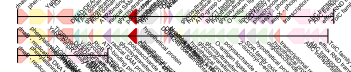

In [66]:
gd_diagram = GenomeDiagram.Diagram(f"{os.path.commonprefix(list(metaDf.Strain_Name.unique()))}{keggToHighlight}")
topStrain=featuresList[0][0]
df=metaDf.copy()
df.loc[df.Strain_Name!=topStrain,'label_angle']=df.loc[df.Strain_Name!=topStrain,'label_angle']-90
for strain,extents,features in featuresList:
    gd_track_for_features = gd_diagram.new_track(1, name=strain,scale=1,scale_ticks=0,start=0, end=extents[1]-extents[0])
    gd_feature_set = gd_track_for_features.new_set()
    for feature in features:
        color = Color(*df.loc[(df.Strain_Name==strain)&(df.hit_ID==feature.qualifiers['locus_tag'][0]),'colour'].values[0])
        name = df.loc[(df.Strain_Name==strain)&(df.hit_ID==feature.qualifiers['locus_tag'][0]),'label'].values[0]
        label_angle=df.loc[(df.Strain_Name==strain)&(df.hit_ID==feature.qualifiers['locus_tag'][0]),'label_angle'].values[0]
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
        
maxLen=np.max([extentTuple[1]-extentTuple[0] for extentTuple in extentTuples])
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((len(featuresList)/3)*inch,(.5+maxLen/10000)*inch),
                fragments=1)# start=0, end=np.max([extentTuple[1]-extentTuple[0] for extentTuple in extentTuples]))
gd_diagram.write(os.path.join(workingDir,'data','genomeDiagram',"output.png"), "png")
gd_diagram.write(os.path.join(workingDir,'data','genomeDiagram',"output.svg"), "svg")
Image(filename=os.path.join(workingDir,'data','genomeDiagram',"output.png"))




In [67]:
def getPaddedGenes(geneListString,numToPad=3):
    baseGenes=[geneName.split(":")[-1] for geneName in geneListString.split(";")]
    if numToPad==0:
        return baseGenes
    else:
        leftPad=[f"{baseGenes[0].split('_')[0]}_{int(baseGenes[0].split('_')[-1])-shift:06d}" for shift in range(1,numToPad+1)]
        rightPad=[f"{baseGenes[-1].split('_')[0]}_{int(baseGenes[-1].split('_')[-1])+shift:06d}" for shift in range(1,numToPad+1)]
        paddedGenes=baseGenes+leftPad+rightPad
        return [gene for gene in paddedGenes]

def generateBGCdf(deepbgcTsvFile):
    strainName=os.path.basename(deepbgcTsvFile).split('_')[0]
    hmsCsvFile=os.path.join(workingDir,'data','kofamscan',f'{strainName}_kofamscan.csv.gz')
    hmsDf=pd.read_csv(hmsCsvFile)
    hmsDf['hit_ID']=[hit_ID.split("|")[-1] for hit_ID in hmsDf.hit_ID]
    deepbgcTsvDf=pd.read_csv(deepbgcTsvFile,sep="\t")
    hmsDf=hmsDf[(hmsDf.hit_bitscore>0.5*hmsDf.bitscore_threshold)&(hmsDf.hit_overlapFrac>0.5)]
    bgcGenesList=[(clusterID,getPaddedGenes(geneListString,numToPad=0)) for clusterID,geneListString in zip(deepbgcTsvDf.bgc_candidate_id,deepbgcTsvDf.protein_ids)]
    
    if len(bgcGenesList)>0:
        bgcDf=pd.concat([hmsDf[hmsDf.hit_ID.isin(bgcGenes)].reset_index(drop=True).merge(kolistDf.reset_index().rename(columns={'knum':'hmm_queryID'}),on='hmm_queryID',how='left').assign(clusterID=f'{strainName}_cluster_{bgcClusterID}') for bgcClusterID,bgcGenes in bgcGenesList])
        bgcDf=bgcDf[['clusterID','hmm_queryID']].drop_duplicates()
    else:
        bgcDf=pd.DataFrame()
    return bgcDf.reset_index(drop=True)


In [68]:
deepbgcTsvFileList=glob(os.path.join(workingDir,'data','deepbgc','*_deepbgc.tsv'))
bgcDf=pd.concat([generateBGCdf(deepbgcTsvFile) for deepbgcTsvFile in deepbgcTsvFileList])


In [69]:
bgcDf['presence']=1
bgcDf=bgcDf.set_index(['clusterID','hmm_queryID']).unstack().fillna(0)
bgcDf=bgcDf.droplevel(0,axis=1)
bgcDf=bgcDf.loc[bgcDf.sum(axis=1)>2,:]
bgcDf=bgcDf.loc[:,bgcDf.sum(axis=0)>2]
print(bgcDf.shape)


(1103, 1387)


<AxesSubplot:ylabel='Count'>

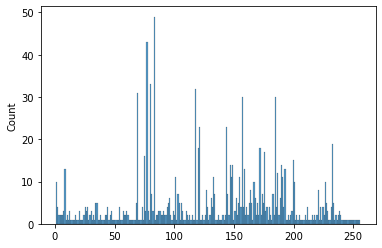

In [70]:
metric='jaccard'
method='weighted'
numClusters=256
clusterLabels=fclusterdata(bgcDf.values, criterion='maxclust',metric=metric,method=method,t=numClusters)
sns.histplot(clusterLabels,bins=numClusters)


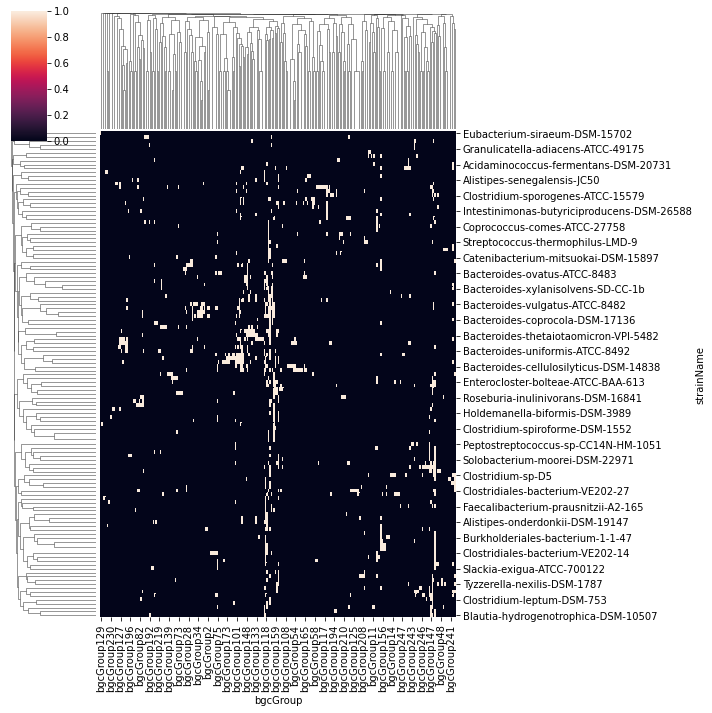

In [71]:

deepbgcDf=pd.DataFrame([f'bgcGroup{clusterLabel}' for clusterLabel in clusterLabels],columns=['bgcGroup'])
deepbgcDf.index=bgcDf.index

deepbgcDf['strainName']=[clusterName.split('_')[0] for clusterName in deepbgcDf.index]

deepbgcDf[0]=1
deepbgcDf=deepbgcDf[['strainName','bgcGroup',0]].drop_duplicates().set_index(['strainName','bgcGroup'],drop=True).unstack().fillna(0)
deepbgcDf.columns=deepbgcDf.columns.droplevel(level=0)
sns.clustermap(deepbgcDf,metric='jaccard',method='weighted')

In [82]:
deepbgcDf=deepbgcDf.loc[deepbgcDf.index.isin(prevalentStrains),:]
deepbgcDf.join(aggregateEnrichments['mucin-agar log carrier enrichment aggregate mean/stdev P3-6']).join(strainInfoDf.set_index('Strain').superphylum).to_csv(os.path.join(workingDir,'data','phylolm','deepbgcInput.csv.gz'))

,estimates,stderrs,tvals,pvals,hues,sizes,effect
bgcGroup157,0.629889,0.068508,9.194429,2.409465e-14,2,2,0.629889
bgcGroup120,0.549858,0.065305,8.419812,8.725573e-13,1,1,0.549858
bgcGroup198,0.472217,0.063028,7.492116,6.238766e-11,1,1,0.472217
bgcGroup34,0.726110,0.097075,7.479873,6.597461e-11,1,1,0.726110
bgcGroup186,0.319430,0.043985,7.262326,1.776664e-10,1,1,0.319430
bgcGroup69,0.546055,0.077205,7.072832,4.191115e-10,1,1,0.546055
bgcGroup161,0.321005,0.045558,7.046036,4.730070e-10,1,1,0.321005


<Figure size 1080x720 with 0 Axes>

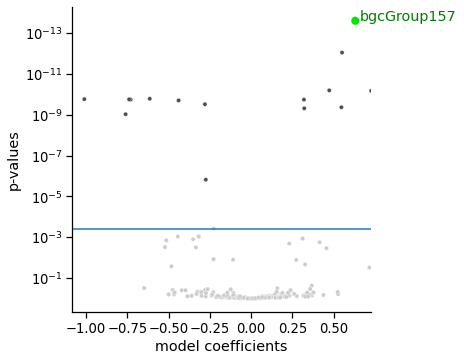

In [83]:
bgcGroupsToHighlight=['bgcGroup157']

plmDf=pd.read_csv(os.path.join(workingDir,"data","phylolm","deepbgcOutput_allPhyla.csv"),index_col=0)
sigThreshold=plmDf.pvals[fdrcorrection(plmDf.pvals,alpha=0.01)[0]].max()

plmDf['hues']=0
plmDf.loc[plmDf.pvals<sigThreshold,'hues']=1
plmDf.loc[plmDf.index.isin(bgcGroupsToHighlight),'hues']=2
plmDf['sizes']=1
plmDf.loc[plmDf.index.isin(bgcGroupsToHighlight),'sizes']=2
plmDf['effect']=plmDf.estimates
plt.figure(figsize=(15,10))
with sns.plotting_context("notebook",font_scale=1.2):

    g=sns.relplot(x='estimates',y='pvals',data=plmDf.sort_values(by='hues'),size='sizes',#alpha=0.2,
                      hue='hues',palette=[[0.8,0.8,0.8],[0.3,0.3,0.3],[0.0,0.9,0.0]],aspect=1,legend=False)
    for ax in g.axes:
        for ax2 in ax:
            
            ax2.invert_yaxis()
            ax2.set_yscale('log')
            ax2.set_xlim(np.quantile(plmDf[f'estimates'],[0.001,0.999]))
            ax2.set_ylabel('p-values')
            ax2.set_xlabel('model coefficients')
            ax2.axhline(sigThreshold)
            for x,y,label in zip(plmDf[f'estimates'], plmDf[f'pvals'],plmDf.index):
                if label in bgcGroupsToHighlight:
                    ax2.text(x+0.03, y, label, horizontalalignment='left', size='medium', color='green')

plmDf[(plmDf['pvals']<sigThreshold)&(plmDf['tvals']>0)]


In [97]:
def makeDFVplot(hmsCsvFile,extents,kofamCounts,clusterGroupDf=None):
    strainName=os.path.basename(hmsCsvFile).split('_')[0]
    gbkFile=os.path.join(workingDir,'data','genomes',f'{strainName}.gbk')
    hmsDf=pd.read_csv(hmsCsvFile)
    strain
    geneDf=hmsDf.rename(columns={'hmm_queryID':'knum'}).merge(kolistDf,how='left',on='knum').sort_values(by='hit_bitscore',ascending=False).sort_values(by='hit_ID',ascending=True)[['hit_ID','hit_description','knum','definition','hit_evalue','hit_bitscore','bitscore_threshold','hit_overlap','hmm_queryLen','hit_overlapFrac']]
    geneDf['hit_ID']=[hit_ID.split('|')[-1] for hit_ID in geneDf.hit_ID]

    records=list(SeqIO.parse(gbkFile, "genbank"))
    graphic_record = BiopythonTranslator().translate_record(records[0])
    cropped_record = graphic_record.crop(extents)

    features=cropped_record.features[1::2]
    features2=cropped_record.features[2::2]

    featureLabels=[feature.label for feature in features]
    numFeatures=len(featureLabels)

    pgapTmpPos=np.where(['pgaptmp_' in featureLabel for featureLabel in featureLabels])
    firstPgapTmpPos=np.min(pgapTmpPos)
    firstPgapTmpLabel=featureLabels[firstPgapTmpPos]
    PgapLabelShift=int(firstPgapTmpLabel.split('_')[-1])-firstPgapTmpPos

    featureLabelsPgap=[f"{firstPgapTmpLabel.split('_')[0]}_{PgapLabelShift+shift:06d}" for shift in range(numFeatures)] 
    matchPos=np.where([featureLabel==featureLabels[ind] for ind,featureLabel in enumerate(featureLabelsPgap)])
    if not np.array_equal(matchPos,pgapTmpPos):
        print('pgaptmp inference failed')
        featureLabelsPgap=None

    subGeneDf=geneDf[geneDf.hit_ID.isin(featureLabelsPgap)]
    subGeneMat=subGeneDf.set_index(['hit_ID','knum'])['hit_bitscore'].unstack().fillna(0)
    subGeneDf.sort_values(by='hit_bitscore',ascending=False).drop_duplicates(subset='hit_ID').sort_values(by='hit_ID')
    subsubGeneDf=subGeneDf.sort_values(by='hit_bitscore',ascending=False).drop_duplicates(subset='hit_ID').sort_values(by='hit_ID')
    subsubsubGeneDf=subGeneDf[(subGeneDf.hit_overlapFrac>0.5) &(subGeneDf.hit_bitscore>0.5*subGeneDf.bitscore_threshold)]    
    if clusterGroupDf is not None:
        clusterGroupDf=pd.read_csv(clusterGroupCsv,index_col=0)
        subsubsubGeneDf=subsubsubGeneDf.set_index('knum').join(kofamCounts.to_frame()).reset_index().rename(columns={0:'geneFreqInClusterGroup','index':'knum'}).fillna(1).sort_values(by=['hit_ID','hit_bitscore'],ascending=[True,False])
        colormap='summer'
        vmin=0
        vmax=subsubsubGeneDf.geneFreqInClusterGroup.max()
        scaleFactor=np.max(np.abs([vmin,vmax]))
        cmap = cm.get_cmap(colormap)
        maxFreqDf=subsubsubGeneDf.groupby('hit_ID')['geneFreqInClusterGroup'].max().reset_index().rename(columns={'geneFreqInClusterGroup':'maxFreq'})
        cmapDict = dict(zip(maxFreqDf.hit_ID,[cmap(0.5+0.5*(freq/scaleFactor)) for freq in maxFreqDf.maxFreq]))
#         plt.colorbar(cm.ScalarMappable(cmap=cm.get_cmap(colormap)))
        subsubsubGeneDf=subsubsubGeneDf.merge(maxFreqDf,on='hit_ID',how='left')
        subsubsubGeneDf['isMax']=['*' if maxFreq==geneFreq else "" for maxFreq,geneFreq in zip(subsubsubGeneDf.maxFreq,subsubsubGeneDf.geneFreqInClusterGroup)]

    for ind,feature in enumerate(features):
        pgapLabel=featureLabelsPgap[ind]
        if clusterGroupCsv is not None:
            try:
                features[ind].color=cmapDict[featureLabelsPgap[ind]]
                features[ind].box_color=cmapDict[featureLabelsPgap[ind]]
            except:
                features[ind].color=(0,0,0,0)
                features[ind].box_color=(0,0,0,0)
        if 'pgap' in feature.label:
            features[ind].label=features2[ind].label
        else:
            features[ind].label=f"{features2[ind].label} - {subGeneDf.loc[subGeneDf.hit_ID==pgapLabel,'hit_description'].values[0].split('[')[0].rstrip()}"
        if pgapLabel in subsubsubGeneDf.hit_ID.values and clusterGroupDf is not None:
            keggIDs=(subsubsubGeneDf.loc[subsubsubGeneDf.hit_ID==pgapLabel,'knum']+subsubsubGeneDf.loc[subsubsubGeneDf.hit_ID==pgapLabel,'isMax']).values
            keggString=', '.join(keggIDs)
            features[ind].label=features[ind].label+f' ({keggString})'

    cropped_record.features=features
    ax, _ = cropped_record.plot(figure_width=(extents[1]-extents[0])*0.00055, max_label_length=2000)
    return ax

<AxesSubplot:>

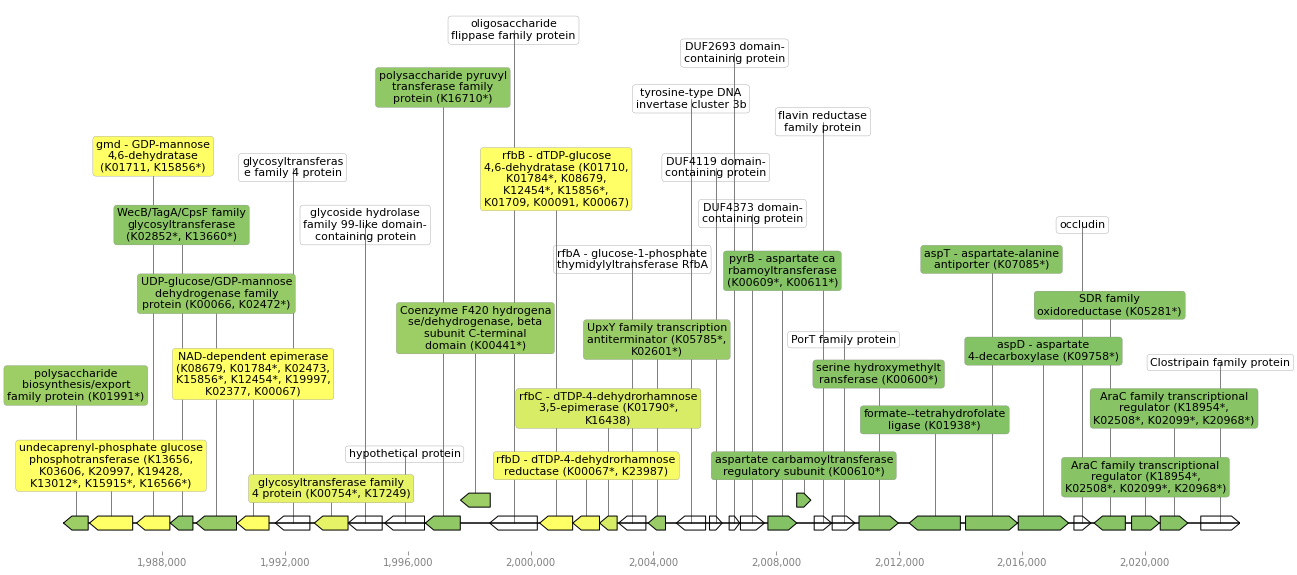

In [98]:
hmsCsvFile=os.path.join(workingDir,'data','kofamscan',"Bacteroides-sp-2-1-22_kofamscan.csv.gz")
extents=(1984776, 2023109)
kofamCounts=bgcDf.iloc[clusterLabels==157,:].sum()
makeDFVplot(hmsCsvFile=hmsCsvFile,extents=extents,kofamCounts=kofamCounts,clusterGroupDf=bgcDf.iloc[clusterLabels==157,:])